In [11]:
import pickle
import pandas as pd
import numpy as np
from sklearn import metrics

import matplotlib.pyplot as plt
%matplotlib inline

# Prime Model Analysis

In [12]:
def load_model_pkl(_path):
    model_training = pickle.load(open(_path, 'rb'))
    model_training_pd = pd.DataFrame(model_training['X'])
    
    if model_training['weights'] is None:
        model_training_pd['count'] = np.ones(len(model_training_pd.index))
    else:
        model_training_pd['count'] = [int(w) for w in model_training['weights']]
        
    model_training_pd['true_y'] = model_training['y']
    model_training_pd['pred_y'] = model_training['y_pred']
    
    #explore benchmark mean & variance
    user_engagements = np.repeat(model_training_pd['true_y'].values, model_training_pd['count'].values)
    print("benchmark: mean user engagement rate:", np.mean(user_engagements), " and std user engagement rate:", np.std(user_engagements))
    mean_user_engagement_rate = np.mean(user_engagements)
    
    model_training_pd['counted_true_y'] = model_training_pd['true_y'] * model_training_pd['count']
    model_training_pd['counted_pred_y'] = model_training_pd['pred_y'] * model_training_pd['count']
    
    # Data Transformation
    group_by_columns = ['agegroup','deviceplatform','engagementofferid','gender','publisherwidgetgroupid','publisherwidgetid','repeatvisitor']
    grouped_obj = model_training_pd.groupby(group_by_columns).agg({'count' : ['sum'], 'counted_true_y' : ['sum'], 'counted_pred_y' : ['sum']})
    grouped_obj.columns = ["_".join(x) for x in grouped_obj.columns.ravel()]
    grouped_obj['avg_true_y'] = grouped_obj['counted_true_y_sum'] / grouped_obj['count_sum']
    grouped_obj['avg_pred_y'] = grouped_obj['counted_pred_y_sum'] / grouped_obj['count_sum']
    grouped_obj.reset_index(inplace=True)
    grouped_obj.sort_values('count_sum', ascending=False, inplace=True)
    
    # ignore combinations without enough training dataset
    grouped_obj = grouped_obj[grouped_obj['count_sum'] >= 1000]
    return grouped_obj, mean_user_engagement_rate
    
def calculate_accuracy(grouped_obj):
    weighted_avg_true_y = np.repeat(grouped_obj['avg_true_y'].values, grouped_obj['count_sum'].values)
    weighted_avg_pred_y = np.repeat(grouped_obj['avg_pred_y'].values, grouped_obj['count_sum'].values)

    print("mean_absolute_error:", metrics.mean_absolute_error(weighted_avg_true_y, weighted_avg_pred_y))
    print("r2_score:", metrics.r2_score(weighted_avg_true_y, weighted_avg_pred_y))

In [13]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 13}

matplotlib.rc('font', **font)

def plot_model_accuracy(grouped_obj, x_label, y_label, title):
    plt.figure(figsize = (12,9))
    plt.plot(grouped_obj['avg_true_y'], grouped_obj['avg_pred_y'], '*')
    plt.plot([0, 1], [0, 1], 'k-')
    plt.axis([0, 1, 0, 1])
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    
def plot_y_dis(user_engagement_rate, mean_user_engagement_rate, x_label, y_label, title):
    plt.figure(figsize = (12,9))
    y, x, _ = plt.hist(user_engagement_rate * 100, bins=100, label="predicted engagement rate with Optimus")
    plt.plot([mean_user_engagement_rate * 100, mean_user_engagement_rate * 100, ], [0, y.max()], label="benchmark: engagement rate without data")
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend()
    plt.title(title)

### Prime A

benchmark: mean user engagement rate: 0.34357971573  and std user engagement rate: 0.474902826554
mean_absolute_error: 0.0122166871792
r2_score: 0.991762296653


/anaconda/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


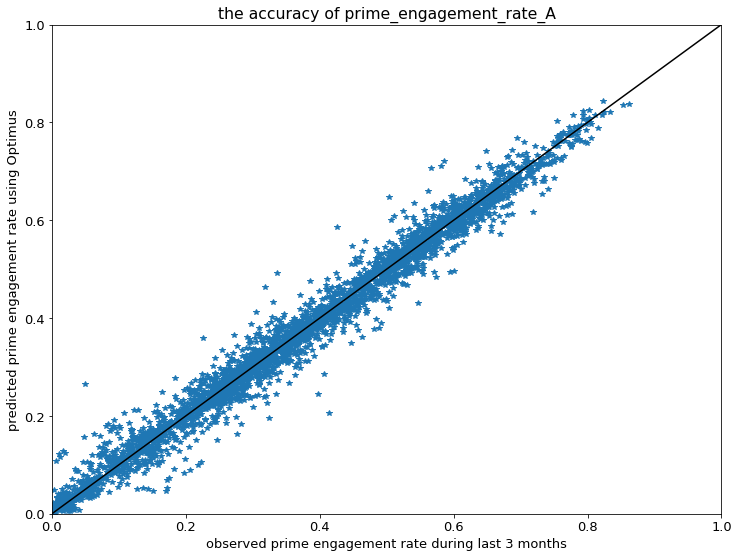

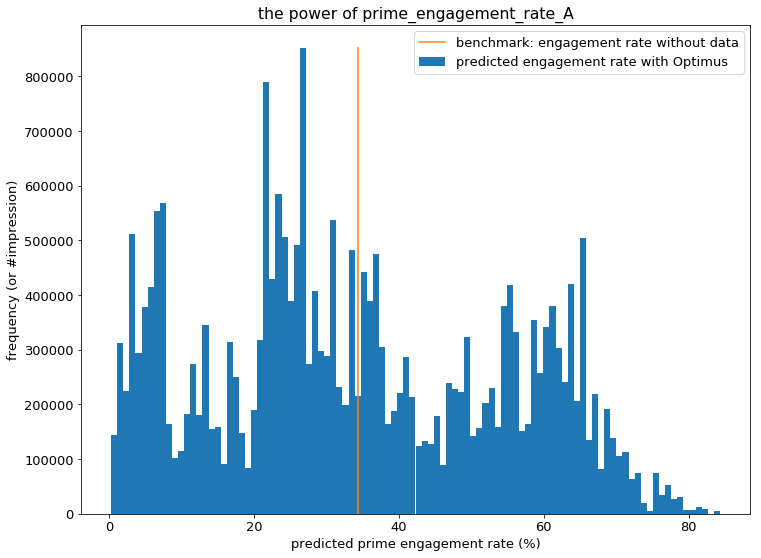

In [14]:
model_name = "prime_engagement_rate_A"
_path = "/Users/xuyan/Documents/workspace/optimus/src/training_prime_model_A_2017-09-07 13:50:35.618958+00:00.pkl"

model_pd, mean_user_engagement_rate = load_model_pkl(_path)

calculate_accuracy(model_pd)

plot_model_accuracy(model_pd, 
                    x_label="observed prime engagement rate during last 3 months", 
                    y_label="predicted prime engagement rate using Optimus", 
                    title="the accuracy of {}".format(model_name))

observed_user_engagement_rate = np.repeat(model_pd['avg_true_y'].values, model_pd['count_sum'].values)
predicted_user_engagement_rate = np.repeat(model_pd['avg_pred_y'].values, model_pd['count_sum'].values)

plot_y_dis(predicted_user_engagement_rate,
           mean_user_engagement_rate,
           x_label="predicted prime engagement rate (%)",
           y_label="frequency (or #impression)", 
           title="the power of {}".format(model_name))

# Notes

### Currently, Optimus accurately captures the knowledge in our training dataset in the last 90 days. Concretely, the model training accuracy is {r2_score: 0.991342236207 and mean_absolute_error: 1%}. Generally, a r2_score >= -.95 and mean_absolute_error < 10% indicates high accuracy. So, Optimus is very accurate.

### However, Optimus is not powerful enough (or have a lot of space for improvement), since Optimus cannot predict Yes/No for a big portion of scenarios. For these scenarios, Optimus is not performing much better than the benchmark (a random guess without any data). The root cause is that our training dataset does not contain enough knowledge to differentiate user decisions. In theory, more attributes are required, or it reflects the natural variance of user decisions.

### Lastly, improving Optimus may or may not improve eCPM. It is a challenging issue. 

# non-prime-B

benchmark: mean user engagement rate: 0.0829171605291  and std user engagement rate: 0.275756967308
mean_absolute_error: 0.00480402874458
r2_score: 0.986966497147


/anaconda/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


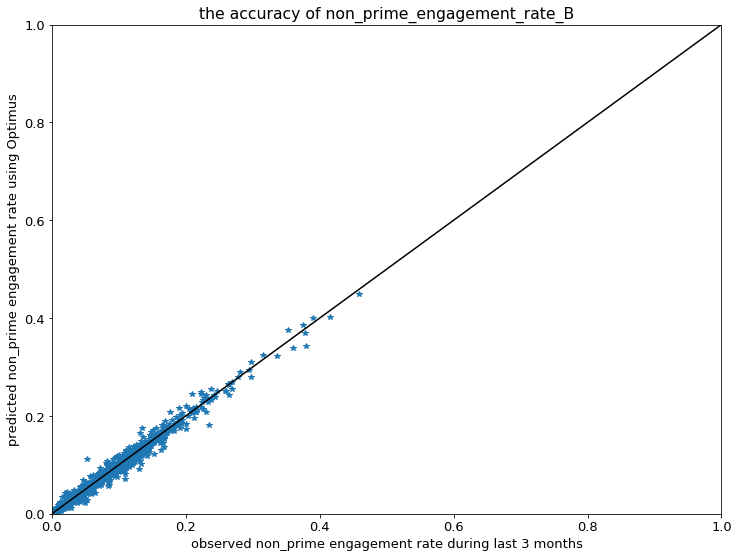

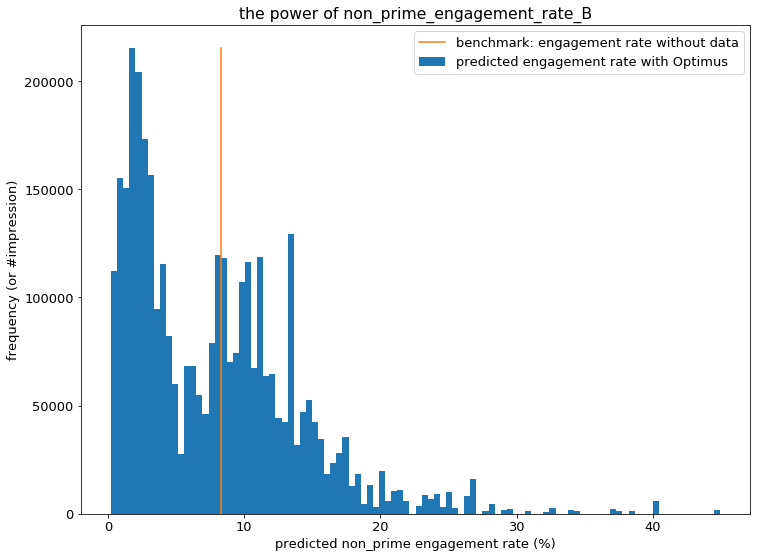

In [5]:
model_name = "non_prime_engagement_rate_B"
_path = "/Users/xuyan/Documents/workspace/optimus/src/training_non_prime_model_B_2017-09-07 13:58:15.420568+00:00.pkl"

model_pd, mean_user_engagement_rate = load_model_pkl(_path)

calculate_accuracy(model_pd)

plot_model_accuracy(model_pd, 
                    x_label="observed non_prime engagement rate during last 3 months", 
                    y_label="predicted non_prime engagement rate using Optimus", 
                    title="the accuracy of {}".format(model_name))

observed_user_engagement_rate = np.repeat(model_pd['avg_true_y'].values, model_pd['count_sum'].values)
predicted_user_engagement_rate = np.repeat(model_pd['avg_pred_y'].values, model_pd['count_sum'].values)

plot_y_dis(predicted_user_engagement_rate,
           mean_user_engagement_rate,
           x_label="predicted non_prime engagement rate (%)",
           y_label="frequency (or #impression)",
           title="the power of {}".format(model_name))

# Notes

### The sumamries for prime A applies for non_prime B

# non-prime-C

In [114]:
model_name = "non_prime_engagement_rate_C"
_path = "/Users/xuyan/Documents/workspace/optimus/src/training_non_prime_C_2017-09-08 02:22:00.777244+00:00.pkl"

model_training = pickle.load(open(_path, 'rb'))
model_training_pd = pd.DataFrame.from_records(model_training['X'])
model_training_pd['true_y'] = pd.to_numeric(model_training['y'])
model_training_pd['pred_y'] = model_training['y_pred']

In [115]:
model_training_pd.head()

agegroup  deviceplatform    engagementofferid gender  \
0         0               2  2362561917979735082          
1         0               2  2357378897475861165      m   
2         5               1  2354250980168364187      m   
3         1               1  2357188733503840538      m   
4         2               1  2386572657770166287      f   

   publisherwidgetgroupid  publisherwidgetid  repeatvisitor    true_y  \
0                     756               6315              0  5.710000   
1                    1090               6606              0  1.480000   
2                     683               5886              0  0.130000   
3                    1085               6506              0  0.470000   
4                    1153               6186              0  4.517671   

     pred_y  
0  1.928045  
1  1.699717  
2  1.709181  
3  1.735713  
4  3.822506

In [120]:
group_by_columns = ['agegroup','deviceplatform','engagementofferid','gender','publisherwidgetgroupid','publisherwidgetid','repeatvisitor']
model_training_groupby_pd = model_training_pd.groupby(group_by_columns).agg({'true_y' : ['mean', 'count', 'std', 'max', 'min'], 'pred_y' : ['mean', 'count', 'std']})
model_training_groupby_pd.columns = ["_".join(x) for x in model_training_groupby_pd.columns.ravel()]
model_training_groupby_pd.reset_index(inplace=True)

### Explore natural variance

In [123]:
model_training_groupby_std_pd = model_training_groupby_pd[model_training_groupby_pd['true_y_count'] > 1000]
model_training_groupby_std_pd.head()

agegroup  deviceplatform    engagementofferid gender  \
237         0               1  2357378897475861165          
349         0               1  2357378897475861165      m   
375         0               1  2359469489987058013      f   
398         0               1  2359759168351300052          
428         0               1  2360160928182059955          

     publisherwidgetgroupid  publisherwidgetid  repeatvisitor  true_y_mean  \
237                    1346               6298              0     1.737564   
349                    1212               6191              0     1.707545   
375                    1121               6154              0     3.362096   
398                     726               6165              0     1.905249   
428                    1212               6191              0     1.774303   

     true_y_count  true_y_std  true_y_max  true_y_min  pred_y_mean  \
237          2003    2.717371   41.790000    0.100000     1.820309   
349          1332    2.576545   46.130000    0.130000     1.649429   
375          1107    3.947825   35.739930    0.287010     3.401547   
398          1375    2.323295   16.668932    0.219807     1.917953   
428          1622    2.528506   39.200000    0.110000     1.788024   

     pred_y_count  pred_y_std  
237          2003         0.0  
349          1332         0.0  
375          1107         0.0  
398          1375         0.0  
428          1622         0.0

/anaconda/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


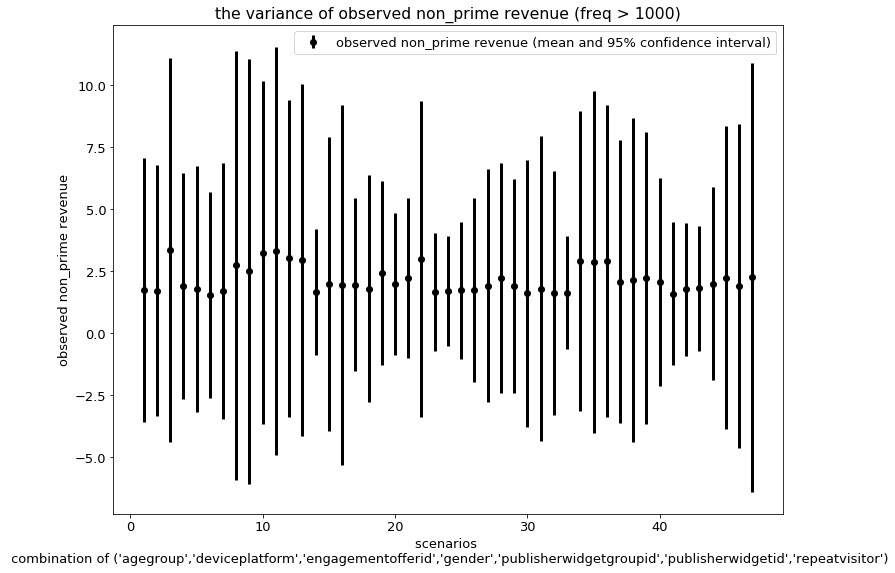

In [126]:
x_index = range(1, len(model_training_groupby_std_pd.index) + 1, 1)

plt.figure(figsize = (12,9))

mean_ = model_training_groupby_std_pd['true_y_mean']
std_ = model_training_groupby_std_pd['true_y_std']
min_ = model_training_groupby_std_pd['true_y_min']
max_ = model_training_groupby_std_pd['true_y_max']
plt.errorbar(x_index, mean_, std_ * 1.96, fmt='ok', lw=3, label="observed non_prime revenue (mean and 95% confidence interval)")

plt.legend()
plt.xlabel("scenarios \n combination of ('agegroup','deviceplatform','engagementofferid','gender','publisherwidgetgroupid','publisherwidgetid','repeatvisitor')")
plt.ylabel("observed non_prime revenue")
plt.title("the variance of observed non_prime revenue (freq > 1000)")

### Explore model acuracy

In [74]:
print("mean_absolute_error:", metrics.mean_absolute_error(model_training_groupby_pd['true_y_mean'], model_training_groupby_pd['pred_y_mean']))
print("r2_score:", metrics.r2_score(model_training_groupby_pd['true_y_mean'], model_training_groupby_pd['pred_y_mean']))

mean_absolute_error: 1.1810743944
r2_score: 0.198122563468


/anaconda/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


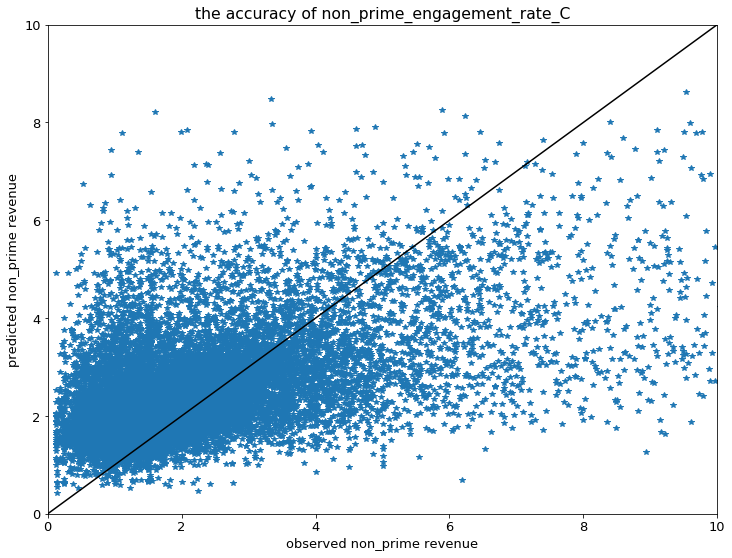

In [75]:
plt.figure(figsize = (12,9))
plt.plot(model_training_groupby_pd['true_y_mean'], model_training_groupby_pd['pred_y_mean'], '*')
plt.plot([0, 10], [0, 10], 'k-')
plt.axis([0, 10, 0, 10])
plt.xlabel("observed non_prime revenue")
plt.ylabel("predicted non_prime revenue")
plt.title("the accuracy of non_prime_engagement_rate_C")

/anaconda/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


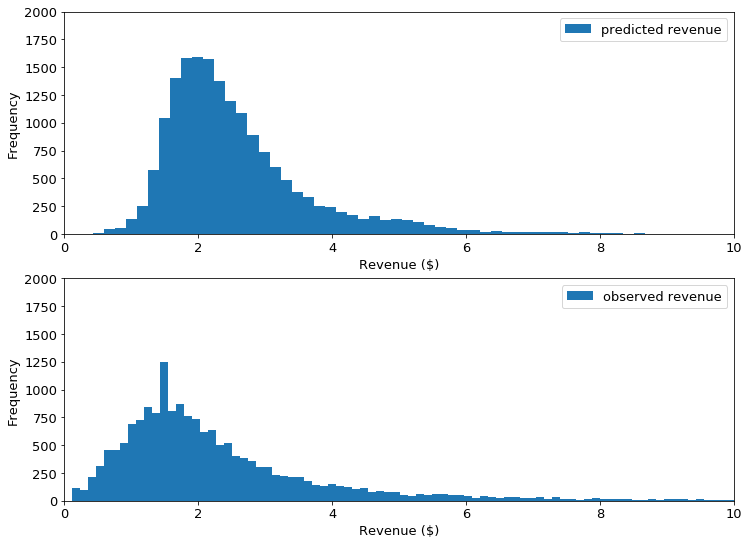

In [78]:
plt.figure(figsize = (12,9))

plt.subplot(211)
plt.hist(model_training_groupby_pd['pred_y_mean'], bins=50, label="predicted revenue")
plt.xlim(0, 10)
plt.ylim(0, 2000)
plt.legend()
plt.xlabel("Revenue ($)")
plt.ylabel("Frequency")

plt.subplot(212)
plt.hist(model_training_groupby_pd['true_y_mean'], bins=1000, label="observed revenue")
plt.xlim(0, 10)
plt.ylim(0, 2000)
plt.legend()
plt.xlabel("Revenue ($)")
plt.ylabel("Frequency")

# Notes

### non-prime-C sucks now. Will focus on it next week.